# Lab session of 17/05/2023

## Graph problem 3: The Traveling Salesperson Problem (TSP)

Find the shortest Hamiltonian circuit through $n$ nodes where the distance between any two nodes is known. In particular:

1. Generate $k$ points by creating random $x,y$ coordinates for each; the coordinates should be in the interval $[0,100]$;
2. Assume the graph $G = (V,E)$ on which to solve the TSP is _complete_, i.e. any two pairs are connected by an edge;
3. Create the optimization model for the TSP by only adding _flow conservation_ constraints, i.e., do not add any subtour elimination constraints;
4. Iteratively solve the optimization model and then add subtour elimination constraints until the solution is a single (optimal) tour.

## Solution

Similar to problem 1 (shortest path tree), we'll perform a step at a time and visualize what we obtain in order to provide some intuition for each step. We'll use similar code for creating coordinates.

In [48]:
# When using Colab, make sure you run this instruction beforehand
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import numpy as np
import math

k = 7  # number of nodes

grid_size = 100 # size of the grid of points

np.random.seed(1337)

# Create k random points with two coordinates. Multiplying by grid_size yields
# random numbers between 0 and 100.
point = grid_size * np.random.random((k,2))

# Define the set of vertices of the graph as the list of numbers from 0 to k-1
V = [i for i in range(k)]

# Determine the distance between each point
distance = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])

Let's plot these points on the grid. We use `matplotlib` and specifically the function `matplotlib.pyplot`. We then create a complete graph and draw it on the grid.

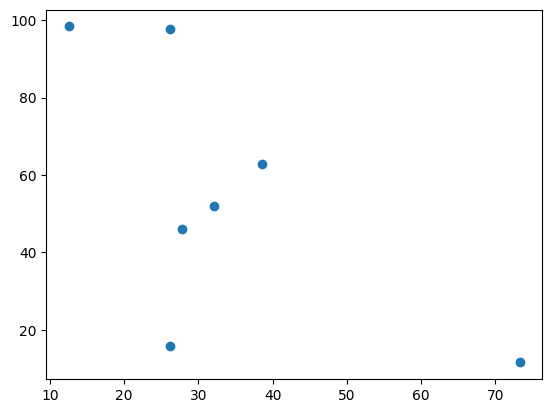

In [50]:
import matplotlib.pyplot as plot
plot.scatter(point[:,0], point[:,1])
plot.show()

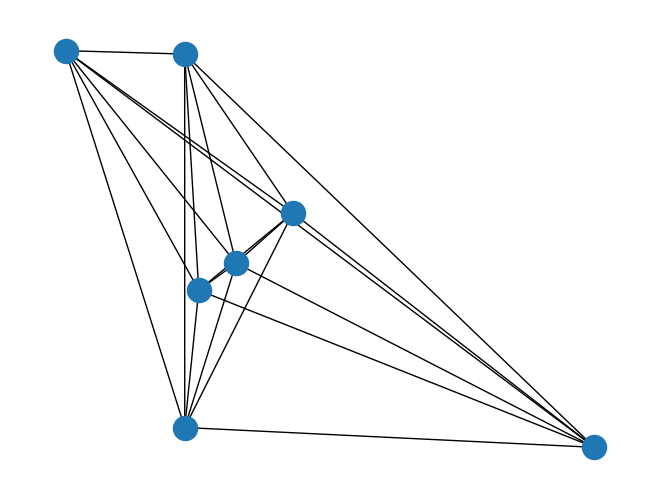

In [51]:
import networkx as nx

# Set of edges: note the condition that i<j as these are edges, not arcs,
# i.e. they are not directed.
E = [(i,j) for i in V for j in V if i < j]

# Define a dictionary whose keys are the nodes, and the values are tuples
# containing the (x,y) coordinates of each point
coord = {i: (point[i,0], point[i,1]) for i in V}

g = nx.Graph()

g.add_nodes_from(V)
g.add_edges_from(E)

nx.draw(g, pos=coord)

We have all data we need and proceed to create a MIP model for the TSP. Let's write the complete one, with the exponentially large set of subtour-elimination constraints:

$$
\begin{array}{lll}
   \min & \sum_{(i,j) \in E} d_{ij} x_{ij}\\
   \textrm{s.t.} & \sum_{j \in V: (i,j) \in E} x_{ij} = 2 & \forall i\in V\\
                 & \sum_{(i,j) \in E: i\in C, j\in C} x_{ij} \le |C| - 1 & \forall C\subset V: C \neq \emptyset\\
                 & x_{ij} \in \{0,1\} & \forall (i,j) \in E
\end{array}
$$

In the first version of our model, we won't include any subtour-elimination constraint but will only add the first set.

In [52]:
# Create model, add variables
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

The flow conservation constraints requires that the incoming flow equal the outgoing flow. Instead of adding these constraints in a loop, we add them using a generator.

In [53]:
# Add conservation constraints
for i in V:
    m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                 mip.xsum(x[i,j] for j in V if j > i) == 2)

The objective function is the same as for the previous problem: the sum over all arcs $(i,j)$ of their length $d_{ij}$ (i.e. the distance between nodes $i$ and $j$) multiplied by the variable $x_{ij}$.

In [54]:
# Add objective function and solve problem
m.objective = mip.minimize(mip.xsum(distance[i,j] * x[i,j] for (i,j) in E))
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

We can rewrite the function for drawing the MIP solution, which might contain subtours.

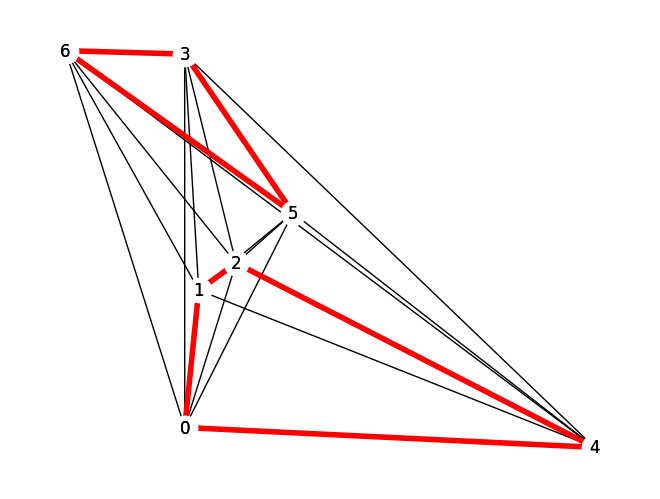

In [55]:
def draw_solution(V, A, x):
    g = nx.Graph()

    # Draw the whole graph first: all nodes, all arcs, no highlighting
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=coord, with_labels=True, node_color="white")

    # Reset the graph and add only the arcs that belong to the solution, 
    # i.e. those for which the optimal value of the variable x[i,j] is nonzero
    g.clear()
    g.add_edges_from([(i,j) for (i,j) in A if x[i,j].x > 0.5])
    nx.draw(g, pos=coord, width=4, edge_color='red', with_labels=True, node_color='white')

    # finally, draw a graph consisting of the sole root node, highlighted in green
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: coord[0]}, node_color='white', with_labels=True)

    
# after defining the function, call it with the current data
draw_solution (V, E, x)

Did we get a Hamiltonian circuit or subtours? In the latter case, we must separate subtour elimination constraints. We do it by hand for the first few iterations.


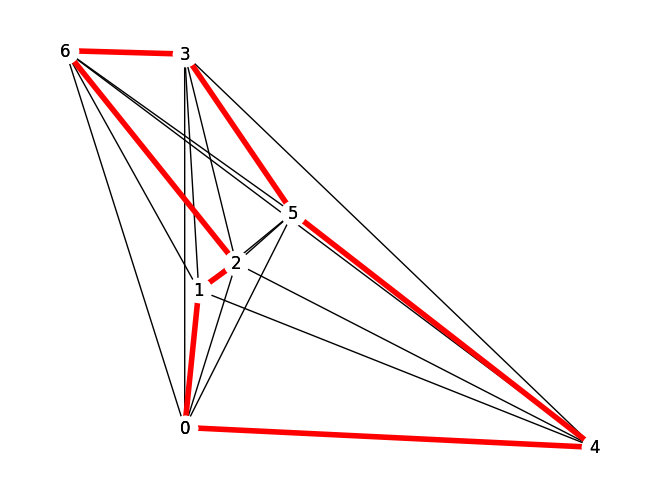

In [56]:
# Prototype:
#
m.add_constr(x[3,5] + x[3,6] + x[5,6] <= 2)
m.optimize()
draw_solution (V, E, x)

## How do we make this automatic? 

How do we repeat this step by adding the appropriate subtour-elimination constraint until we find a Hamiltonian circuit?



In [57]:
# returns a list of cycles (list of vertices) in the solution
def get_cycles(V, E, x):
  graph = [[] for i in V]

  for (i,j) in E:
    if x[i,j].x > 0.5:
      graph[i].append(j)
      graph[j].append(i)

  cycles = []
  color = [0 for i in V]
  par = [-1 for i in V]

  for i in V:
    if par[i] == -1:
      dfs_cycle(graph, cycles, i, -1, color, par)

  return [c for c in cycles if len(c) < len(V) and len(c) > 0]

# depth first search algorithm
def dfs_cycle(graph, cycles, u, p, color, par):
    # skip completely visited vertex.
    if color[u] == 2:
        return
 
    # If vertex has been seen but not completely visited -> cycle detected.
    # Backtrack based on parents to find the complete cycle.
    if color[u] == 1:
        v = []
        cur = p
        v.append(cur)
 
        # backtrack the vertex which are
        # in the current cycle thats found
        while cur != u:
            cur = par[cur]
            v.append(cur)
        
        cycles.append(v)
        return
 
    par[u] = p
 
    # partially visited.
    color[u] = 1
 
    # simple dfs on graph
    for v in graph[u]:
        # if it has not been visited previously
        if v == par[u]:
            continue
        dfs_cycle(graph, cycles, v, u, color, par)
 
    # completely visited.
    color[u] = 2

Added: constr(7): +1.0 x01 +1.0 x02 +1.0 x04 +1.0 x12 +1.0 x14 +1.0 x24 <= 5.0
Added: constr(8): +1.0 x35 +1.0 x36 +1.0 x56 <= 2.0
247.709309381665


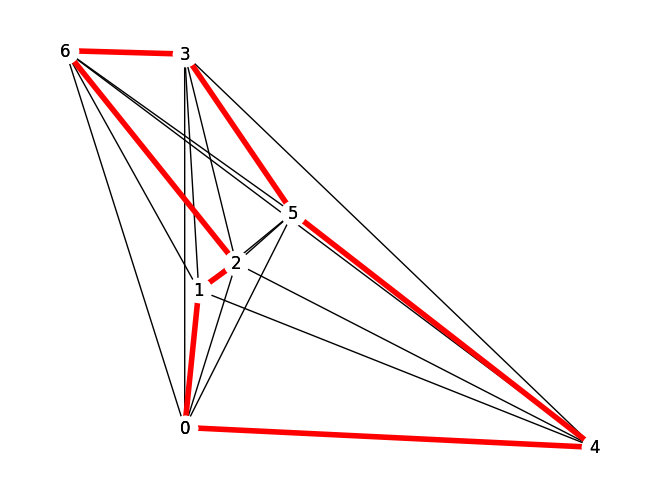

In [58]:
import mip


m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY, name="x{}{}".format(str(i), str(j))) for (i,j) in E}

for i in V:
    m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                 mip.xsum(x[i,j] for j in V if j > i) == 2)

m.objective = mip.minimize(mip.xsum(distance[i,j] * x[i,j] for (i,j) in E))
m.optimize()

cycles = get_cycles(V, E, x)
iters = 0
while len(cycles) > 0:
  for cycle in cycles:
    cycle_edges = [x[i,j] for (i,j) in E if i in cycle and j in cycle and i < j]
    c = m.add_constr(mip.xsum(cycle_edges) <= len(cycle_edges) - 1)
    print("Added:", c)

  m.optimize()
  cycles = get_cycles(V, E, x)
  iters += 1
  if iters > 10:
    break

print(m.objective_value)
draw_solution (V, E, x)

## How this performs w.r.t. a model with all subtour-elimination constraints?



In [59]:
def solve_with_cut_generation(V, E, distance):
  m = mip.Model()

  x = {(i,j): m.add_var(var_type=mip.BINARY, name="x{}{}".format(str(i), str(j))) for (i,j) in E}

  for i in V:
      m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                  mip.xsum(x[i,j] for j in V if j > i) == 2)

  m.objective = mip.minimize(mip.xsum(distance[i,j] * x[i,j] for (i,j) in E))
  m.optimize()

  cycles = get_cycles(V, E, x)
  iters = 0
  while len(cycles) > 0:
    for cycle in cycles:
      cycle_edges = [x[i,j] for (i,j) in E if i in cycle and j in cycle and i < j]
      c = m.add_constr(mip.xsum(cycle_edges) <= len(cycle_edges) - 1)
      print("Added:", c)

    m.optimize()
    cycles = get_cycles(V, E, x)
    iters += 1
    if iters > 10:
      break

  return m.objective_value


def solve_with_complete_model(V, E, distance):
  m = mip.Model()

  x = {(i,j): m.add_var(var_type=mip.BINARY, name="x{}{}".format(str(i), str(j))) for (i,j) in E}

  for i in V:
      m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                  mip.xsum(x[i,j] for j in V if j > i) == 2)
      
  from itertools import chain, combinations
  powerset = list(chain.from_iterable(combinations(V, r) for r in V))

  for S in powerset:
    if len(S) > 0 and len(S) < k:
        m.add_constr(mip.xsum(x[i,j] for i in S for j in S if i < j) <= len(S) - 1)

  m.objective = mip.minimize(mip.xsum(distance[i,j] * x[i,j] for (i,j) in E))
  m.optimize()

  return m.objective_value

%time print("Cut generation obj:", solve_with_cut_generation(V, E, distance))
%time print("Complete model obj:", solve_with_complete_model(V, E, distance))

Added: constr(7): +1.0 x01 +1.0 x02 +1.0 x04 +1.0 x12 +1.0 x14 +1.0 x24 <= 5.0
Added: constr(8): +1.0 x35 +1.0 x36 +1.0 x56 <= 2.0
Cut generation obj: 247.709309381665
CPU times: user 17.6 ms, sys: 0 ns, total: 17.6 ms
Wall time: 22.4 ms
Complete model obj: 247.709309381665
CPU times: user 28.7 ms, sys: 0 ns, total: 28.7 ms
Wall time: 31.3 ms
